# Exploratory Analysis of the Datasets

In [1]:
import pandas as pd
import numpy as np
import json
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
import re
from pathlib import Path   
import plotly.express as px
from transformers import BertTokenizer 
from sklearn.metrics.pairwise import cosine_similarity
import random

c:\Users\alexy\environments\dsai-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def text_preprocessing(text):
    stop_words = ENGLISH_STOP_WORDS
    wordnet_lemmatizer=WordNetLemmatizer()
    
    # remove punctuations
    text=text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    translation_table = str.maketrans('', '', string.digits)
    text=text.translate(translation_table)
    # remove URL
    text=text.replace(r'\s*https?://\S+(\s+|$)', ' ').strip()
    # remove stopwords
    text=' '.join([word for word in text.split() if word not in (stop_words)])
    # simple tokenisation using NLTK
    text=nltk.word_tokenize(text)
    # lemmatization
    text=([wordnet_lemmatizer.lemmatize(w) for w in text])

    return text

In [3]:
def plot_similarity(features, labels, title='Semantic Textual Similarity'):
  """
  Plot a similarity matrix of the embeddings.
  Reference code taken from: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d
  """
  plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cosine_similarity(features), xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Greens", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title(title)


In [4]:
def create_attention_masks(sentence, max_length):
    """ Creating the specifically formatted inputs for BERT. """
    # load the pre-trained tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    # initialise the input arrays
    input_ids = []
    token_type_ids = []
    attention_masks = []
    # iterate through the sentences to generate the inputs for BERT
    for headline in sentence:
        tokenized_texts = tokenizer.encode_plus(" ".join(headline),
                                                    add_special_tokens=True,
                                                    max_length=max_length,
                                                    padding='max_length',
                                                    truncation=True,
                                                    return_attention_mask=True)
        input_ids.append(tokenized_texts['input_ids'])
        token_type_ids.append(tokenized_texts['token_type_ids'])
        attention_masks.append(tokenized_texts['attention_mask'])
   
    return input_ids, token_type_ids, attention_masks

In [5]:
# for illustration purposes
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sentence = 'I love CZ4042!'
tokenized_texts = tokenizer.encode_plus(" ".join(sentence),
                                            add_special_tokens=True,
                                            max_length=20,
                                            padding='max_length',
                                            truncation=True,
                                            return_attention_mask=True)
print('MAX_LENGTH = ', 20)
print('ORIGINAL SENTENCE: ', sentence)
print('input_ids: ', tokenized_texts['input_ids'])
print('attention_mask: ', tokenized_texts['attention_mask'])
print('token_type_ids: ', tokenized_texts['token_type_ids'])

In [ ]:
def plot_classes(df, type='bar', title='Financial Headline', col='News'):
    fig = px.bar(df.groupby('Class').count()) if type=='bar' else px.pie(names=df.groupby('Class').count().index, values=df.groupby('Class').count()[col])
    fig.update_layout(
        title=f'Count per class for {title} Dataset',
        height=500,
        width=500
    )
    fig.update_xaxes(title='Sentiment')
    fig.update_yaxes(title='Count of values')
    fig.show()

In [ ]:
from collections import Counter
import itertools
def plot_common_words_count(df, col='News', dataset='A'):
    tokens = [[word for word in item if len(word) > 2] for item in df[col]]
    last_token = list(itertools.chain(*tokens))  
    bow_simple = Counter(last_token).most_common(15) 

    labels = [item[0] for item in bow_simple]
    number = [item[1] for item in bow_simple]
    nbars = len(bow_simple)

    plt.grid(zorder=0)
    plt.bar(np.arange(nbars), number, tick_label=labels, zorder=3)
    plt.xticks(rotation=45)
    plt.title(f'Most Common Words in Dataset {dataset}')
    plt.ylabel('Count')
    plt.show()

## Dataset A

In [ ]:
f_news_df = pd.read_csv("data/Financial_News.csv",encoding='ISO-8859-1', header = None)
f_news_df.columns=["Class", "News"]
f_news_df = f_news_df.dropna()
f_news_df.head()
print(f_news_df.shape)

(4846, 2)


In [ ]:
f_news_df.groupby('Class').count()

,News
Class,
negative,604
neutral,2879
positive,1363


In [ ]:
plot_classes(f_news_df)
plot_classes(f_news_df, type='pie')

There is an uneven class distribution which can affect the model's performance. 

In [ ]:
f_news_df['News']=f_news_df['News'].apply(lambda x: x.lower())
f_news_df['News']=f_news_df['News'].apply(lambda x:text_preprocessing(x))

In [ ]:
f_news_df.head()

,Class,News
0,neutral,"[according, gran, company, plan, production, r..."
1,neutral,"[technopolis, plan, develop, stage, area, squa..."
2,negative,"[international, electronic, industry, company,..."
3,positive,"[new, production, plant, company, increase, ca..."
4,positive,"[according, company, s, updated, strategy, yea..."


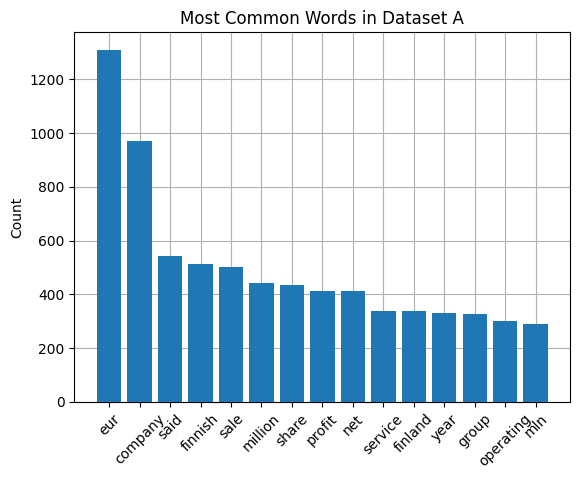

In [ ]:
plot_common_words_count(f_news_df)

In [ ]:
# split into train test sets
X = f_news_df['News']
y = f_news_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# filepath1 = Path('fnews_Xtrain.csv')   
# X_train.to_csv(filepath1)
# filepath2 = Path('fnews_Xtest.csv')   
# X_test.to_csv(filepath2)
# filepath3 = Path('fnews_ytrain.csv')   
# y_train.to_csv(filepath3)
# filepath4 = Path('fnews_ytest.csv')   
# y_test.to_csv(filepath4)

Train shape:  3100 3100 3100 3100
Val shape:  776 776 776 776
Test shape:  970 970 970 970


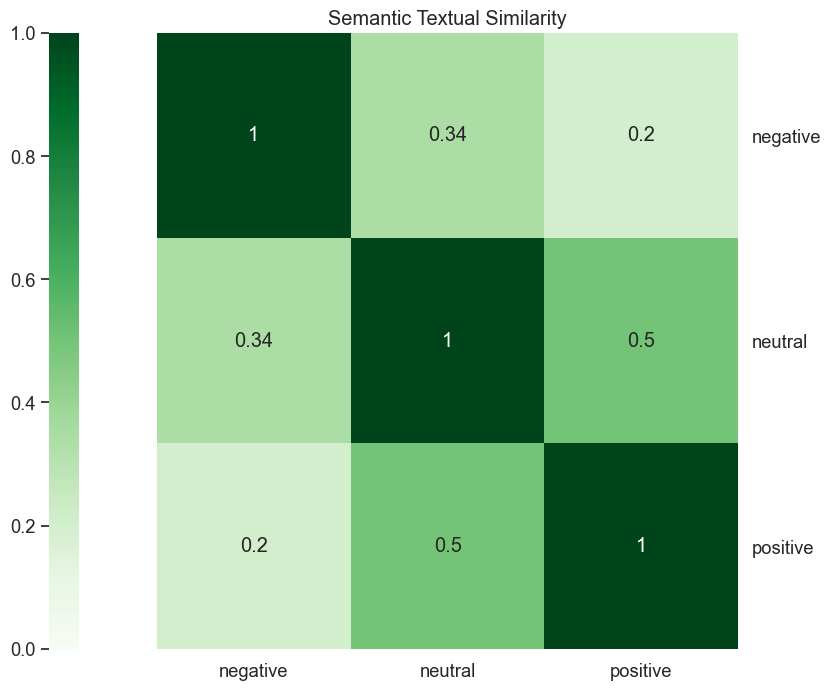

In [ ]:
import random
train_labels = y_train.map({'neutral':1, 'positive': 2, 'negative': 0}).values
test_labels = y_test.map({'neutral':1, 'positive': 2, 'negative': 0}).values

train_input_ids, train_tokens, train_attention_masks = create_attention_masks(X_train, 150)
test_input_ids, test_tokens, test_attention_masks = create_attention_masks(X_test, 150)
ttrain_input_ids, val_input_ids, ttrain_tokens, val_tokens, ttrain_attention_masks, val_attention_masks, ttrain_labels, val_labels  = train_test_split(train_input_ids, train_tokens, train_attention_masks, train_labels, test_size=0.2)
print('Train shape: ', len(ttrain_input_ids), len(ttrain_tokens), len(ttrain_attention_masks), len(ttrain_labels))
print('Val shape: ', len(val_input_ids), len(val_tokens), len(val_attention_masks), len(val_labels))
print('Test shape: ', len(test_input_ids), len(test_tokens), len(test_attention_masks), len(test_labels))

sentiments = ["negative", "neutral", "positive"]

# comparing a random sample from each
neg_samples = np.array(ttrain_input_ids)[ttrain_labels==0]
neu_samples = np.array(ttrain_input_ids)[ttrain_labels==1]
pos_samples = np.array(ttrain_input_ids)[ttrain_labels==2]
plot_similarity([
  neg_samples[random.randint(0, len(neg_samples)-1)], 
  neu_samples[random.randint(0, len(neu_samples)-1)], 
  pos_samples[random.randint(0, len(pos_samples)-1)]
  ], sentiments)

## Dataset B

In [ ]:
squidgame_df=pd.read_csv("data/Squid_Game.csv")
squidgame_df=squidgame_df.dropna()
squidgame_df.drop(squidgame_df.columns[[0,1,2,4]], axis=1, inplace=True)
squidgame_df.head()
squidgame_df.rename(columns={'Review Rating':'Class', 'Review_body':'Review'}, inplace = True)
squidgame_df['Review'] = squidgame_df['Review'].apply(lambda x:text_preprocessing(x.lower()))

In [ ]:
squidgame_df.head()

,Class,Review
0,10/10,"[just, finished, squid, game, korean, tv, that..."
1,9/10,"[multiple, game, actually, accurate, look, way..."
2,10/10,"[runaway, hit, south, korea, centred, seong, g..."
3,5/10,"[went, knowing, absolutely, korean, series, an..."
4,7/10,"[honestly, dont, know, wtf, main, character, n..."


In [ ]:
squidgame_df['Class'].unique()
squidgame_df['Class'] = squidgame_df['Class'].replace(['1/10','2/10','3/10', '4/10'],'negative')
squidgame_df['Class'] = squidgame_df['Class'].replace(['5/10'],'neutral')
squidgame_df['Class'] = squidgame_df['Class'].replace(['6/10','7/10','8/10','9/10','10/10'],'positive')

In [ ]:
plot_classes(squidgame_df, title='Review', col='Review')
plot_classes(squidgame_df, type='pie', title='Review', col='Review')

Even worse class distribution...

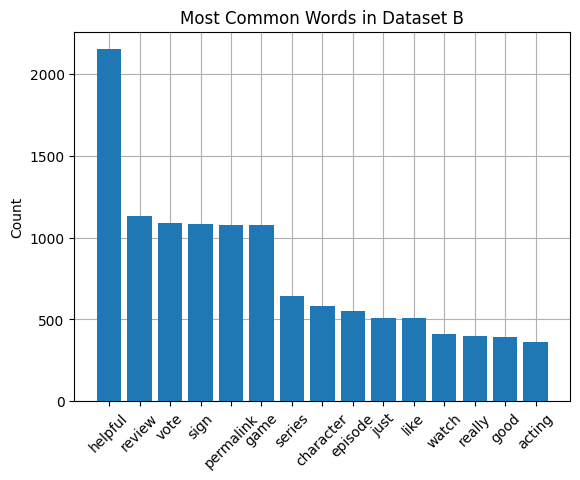

In [ ]:
plot_common_words_count(squidgame_df, col='Review', dataset='B')

In [ ]:
# split into train test sets
X = squidgame_df['Review']
y = squidgame_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# filepath1 = Path('data/train/squidgame_Xtrain.csv')   
# X_train.to_csv(filepath1)
# filepath2 = Path('data/test/squidgame_Xtest.csv')   
# X_test.to_csv(filepath2)
# filepath3 = Path('data/train/squidgame_ytrain.csv')   
# y_train.to_csv(filepath3)
# filepath4 = Path('data/test/squidgame_ytest.csv')   
# y_test.to_csv(filepath4)

In [ ]:
# mapping the classes to a numeric representation
sg_train_labels = y_train.map({'neutral':1, 'positive': 2, 'negative': 0}).values
sg_test_labels = y_test.map({'neutral':1, 'positive': 2, 'negative': 0}).values

In [ ]:
sg_train_input_ids, sg_train_tokens, sg_train_attention_masks = create_attention_masks(X_train, 150)
sg_test_input_ids, sg_test_tokens, sg_test_attention_masks = create_attention_masks(X_test, 150)
sg_ttrain_input_ids, sg_val_input_ids, sg_ttrain_tokens, sg_val_tokens, sg_ttrain_attention_masks, sg_val_attention_masks, sg_ttrain_labels, sg_val_labels  = train_test_split(sg_train_input_ids, sg_train_tokens, sg_train_attention_masks, sg_train_labels, test_size=0.2)
print('Train shape: ', len(sg_ttrain_input_ids), len(sg_ttrain_tokens), len(sg_ttrain_attention_masks), len(sg_ttrain_labels))
print('Val shape: ', len(sg_val_input_ids), len(sg_val_tokens), len(sg_val_attention_masks), len(sg_val_labels))
print('Test shape: ', len(sg_test_input_ids), len(sg_test_tokens), len(sg_test_attention_masks), len(sg_test_labels))

Train shape:  3100 3100 3100 3100
Val shape:  776 776 776 776
Test shape:  970 970 970 970


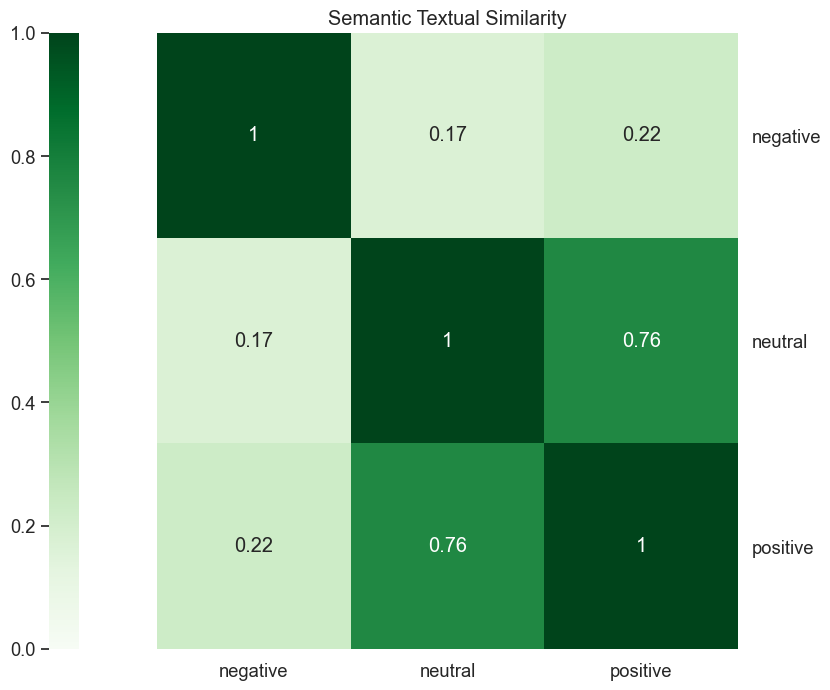

In [ ]:
sentiments = ["negative", "neutral", "positive"]

# comparing a random sample from each
sg_neg_samples = np.array(sg_ttrain_input_ids)[sg_ttrain_labels==0]
sg_neu_samples = np.array(sg_ttrain_input_ids)[sg_ttrain_labels==1]
sg_pos_samples = np.array(sg_ttrain_input_ids)[sg_ttrain_labels==2]
plot_similarity([
  neg_samples[random.randint(0, len(sg_neg_samples)-1)], 
  neu_samples[random.randint(0, len(sg_neu_samples)-1)], 
  pos_samples[random.randint(0, len(sg_pos_samples)-1)]
  ], sentiments)

# Comparing Both Datasets

In [ ]:
neg_cosine_sim = []
for x in sg_neg_samples:
    for y in neg_samples:
        neg_cosine_sim.append(cosine_similarity([x,y]))
print("Cosine Similarity for Negative Sentiments in Datasets A and B: ", np.mean(neg_cosine_sim))

c:\Users\alexy\environments\dsai-env\lib\site-packages\sklearn\metrics\pairwise.py:45: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: setting an array element with a sequence.

In [ ]:
pos_cosine_sim = []
for x in sg_pos_samples:
    for y in pos_samples:
        pos_cosine_sim.append(cosine_similarity([x,y]))
print("Cosine Similarity for Positive Sentiments in Datasets A and B: ", np.mean(pos_cosine_sim))

c:\Users\alexy\environments\dsai-env\lib\site-packages\sklearn\metrics\pairwise.py:45: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: setting an array element with a sequence.

In [ ]:
neu_cosine_sim = []
for x in sg_neu_samples:
    for y in neu_samples:
        neu_cosine_sim.append(cosine_similarity([x,y]))
print("Cosine Similarity for Neutral Sentiments in Datasets A and B: ", np.mean(neu_cosine_sim))

c:\Users\alexy\environments\dsai-env\lib\site-packages\sklearn\metrics\pairwise.py:45: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: setting an array element with a sequence.